# For Tianyi, an example of estimating at each step, translation, rotation and depth (plotted at the end)

In [2]:
import os
import multiprocessing
import numpy as np
import scipy.linalg as linalg
from JSAnimation import IPython_display
import matplotlib.pyplot as plt
from matplotlib import animation
import itertools
from optic_flow import *
from test_subpsace import *
from multiprocessing import Pool, Manager, Process,TimeoutError
import time
import scipy.io;

Start to load all the data:


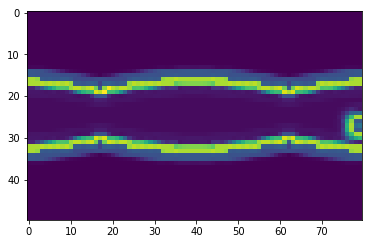


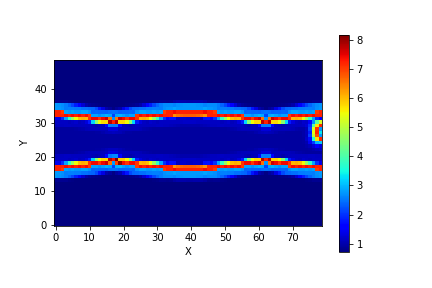
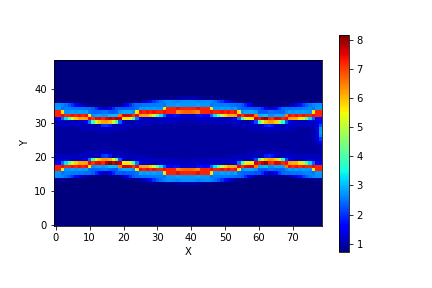
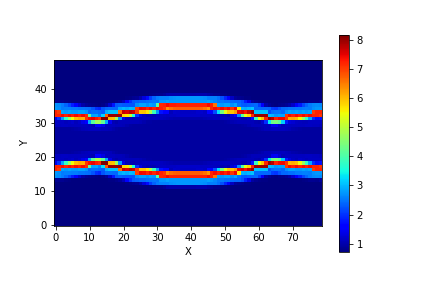
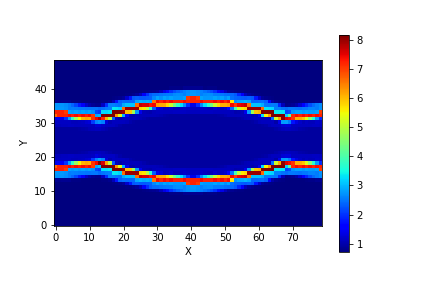
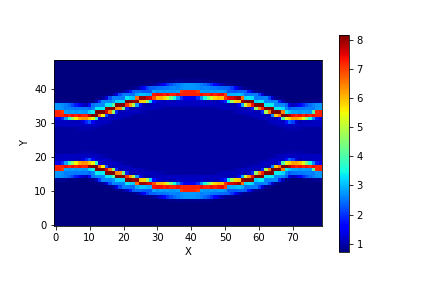
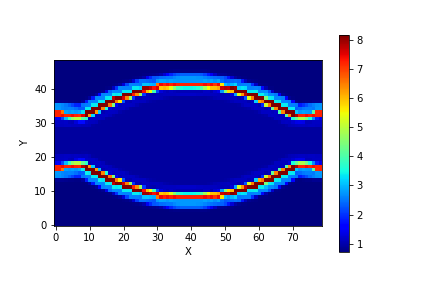
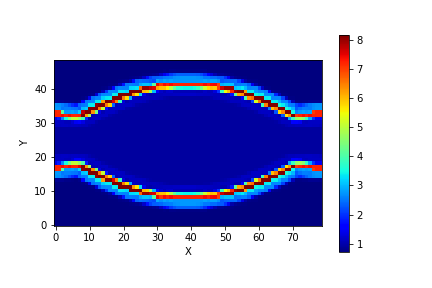
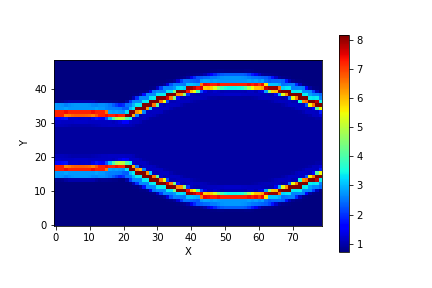
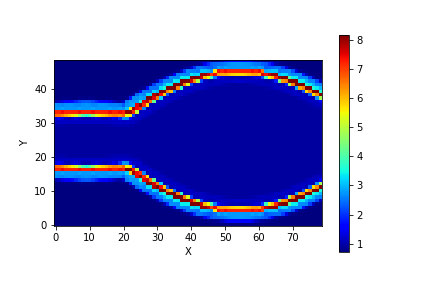

In [63]:
%matplotlib inline

def animate(i):
    im.set_array(stimulus[i,:,:])
    return im

## load trajectory data
# Now load in the data from the .mat that was saved
matFileData = './data/trajEvalData.mat';
matData = scipy.io.loadmat(matFileData);
print('Start to load all the data:');
x = matData['x'];
y = matData['y'];
xIdx = matData['xIdx'];
yIdx = matData['yIdx'];
bagOfData = matData['bagOfData'];
bagOfDir = -(matData['bagOfDir'] - 180.0);
bagOfDir[np.where(bagOfDir == 180)] = -180;
angStep = 360.0 / bagOfData.shape[1];

plt.figure();
plt.imshow(np.reshape(bagOfData[0, 0, :], (50, 80)));
plt.show();

stimulus = np.reshape(bagOfData, (bagOfData.shape[0], 50, 80));

stimulus = stimulus[:9, 0:49, 0:79];
im_shape = stimulus.shape;



vmin1 = stimulus.min(); vmax1 = stimulus.max()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(stimulus[0,:,:], cmap="jet",origin="lower")
fig.colorbar(im)
animation.FuncAnimation(fig, animate, frames=stimulus.shape[0], interval=10)

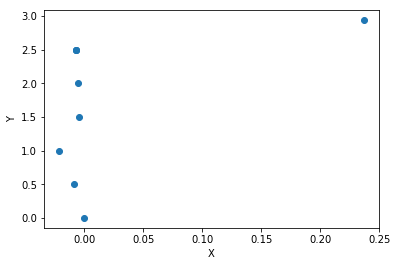

In [77]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.plot(x[0,0:9],y[0,0:9],'o')
plt.savefig('figs/path2.png',bbox_inches='tight')

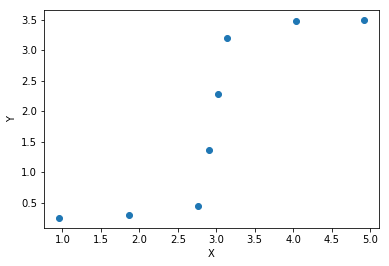

In [83]:
x = (0.96,0.90,0.90,0.14,0.12,0.12,0.90,0.88)
z = (0.25,0.04,0.15,0.92,0.92,0.92,0.27,0.02)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.plot(np.cumsum(x),np.cumsum(z),'o')
plt.savefig('figs/path23.png',bbox_inches='tight')

In [79]:
np.cumsum(x)

array([ 0.  ,  0.96,  1.86,  2.  ,  2.12,  2.24,  3.14,  4.02])

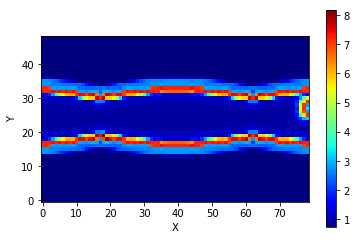

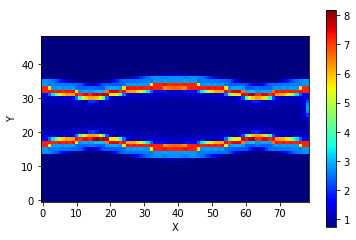

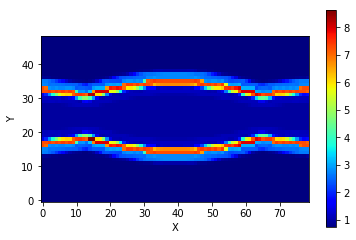

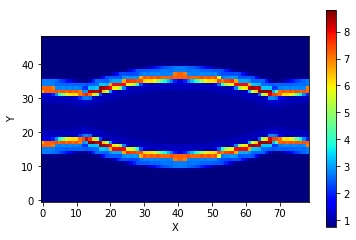

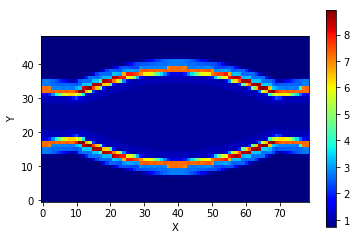

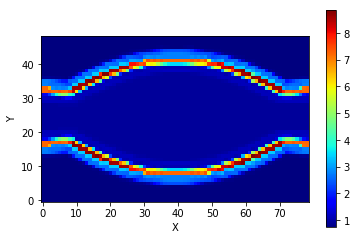

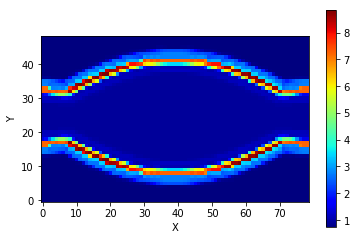

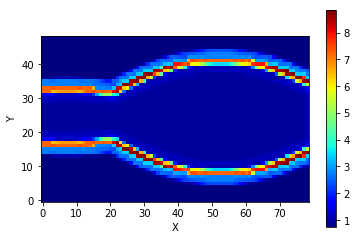

In [57]:
for i in range(8):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    im = ax.imshow(stimulus[i,:,:], cmap="jet",origin="lower")
    fig.colorbar(im)
    plt.savefig('figs/one_point_arrow{}.png'.format(i),bbox_inches='tight')

In [44]:
# import matlab.engine
# eng = matlab.engine.start_matlab()
# stimulus2 = eng.optic_flow(200, 0.,  0., .5, 1);
# stimulus2 = np.array(stimulus2)

print(stimulus.shape)

(9, 49, 79)


In [45]:
%%time

v_x, v_y = optic_flow(stimulus)

CPU times: user 116 ms, sys: 316 ms, total: 432 ms
Wall time: 5.77 s


In [46]:
im_shape = np.shape(v_x)
print(im_shape)

(9, 49, 79)


In [47]:
np.save('stimulus/tianyi_shape{}.npy'.format(im_shape),(v_x,v_y))

In [48]:
temp_v_x, temp_v_y = np.load('stimulus/tianyi_shape{}.npy'.format(im_shape))
video_v_x, video_v_y = temp_v_x, temp_v_y
im_shape = np.shape(video_v_x)

In [49]:
im_shape

(9, 49, 79)


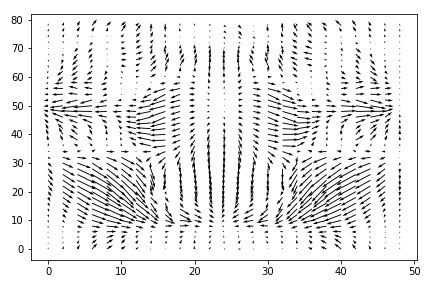
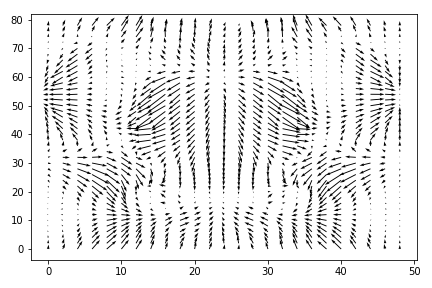
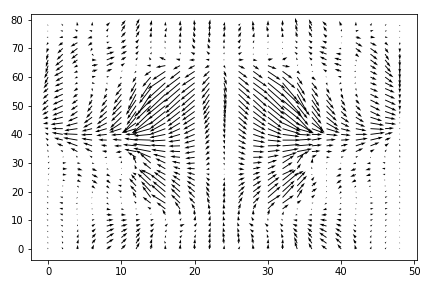
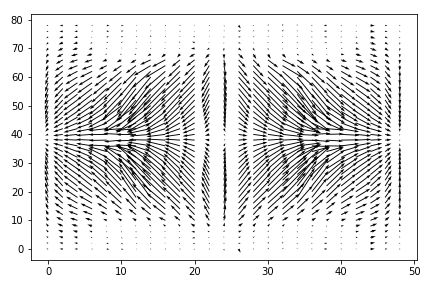
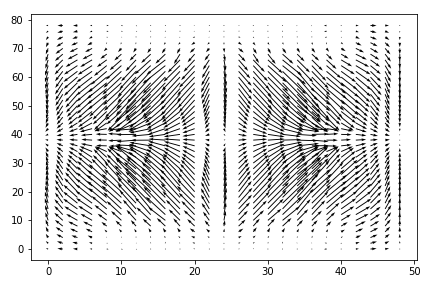
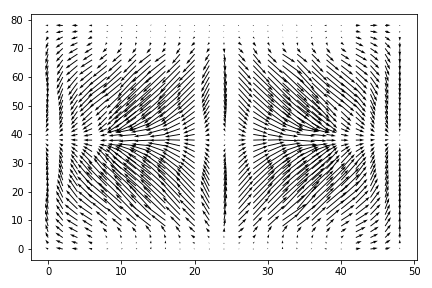
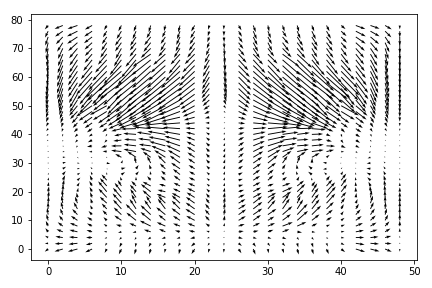
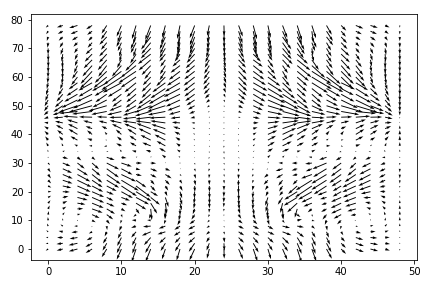
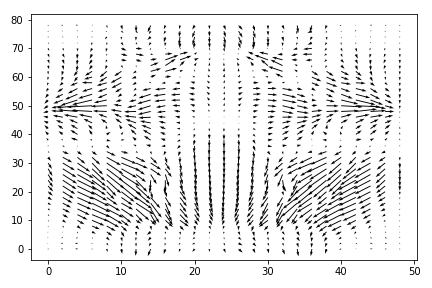

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
spacing = 2
time = im_shape[0]
x_shape = im_shape[1]
y_shape = im_shape[2]
im_show = []
(X, T, Y) = np.meshgrid(np.arange(0, x_shape), np.arange(0, time), np.arange(0, y_shape))
Q = ax.quiver(X[0,::spacing,::spacing], Y[0,::spacing,::spacing], 
                   video_v_x[0,::spacing,::spacing], video_v_y[0,::spacing,::spacing], 
                    pivot='tail', color='k', units='xy', scale = .05)
im_show.append(Q)
def animate(i):  
    """
        Dynamically setting what is displayed on the different plots.
    """
    im_show[0].set_UVC(video_v_x[i,::spacing,::spacing],video_v_y[i,::spacing,::spacing])
    return im_show
plt.tight_layout()

animation.FuncAnimation(fig, animate, frames=T.shape[0], interval=50)

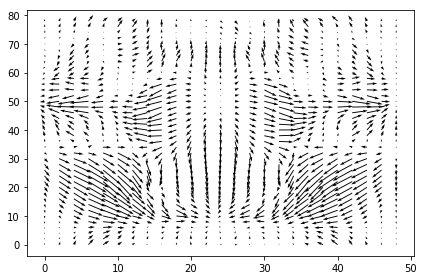

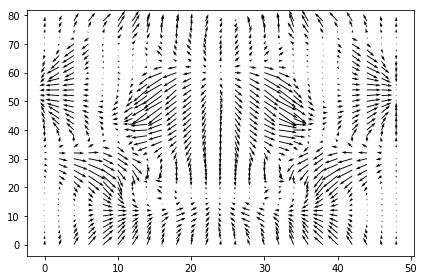

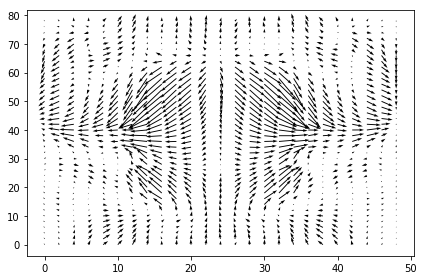

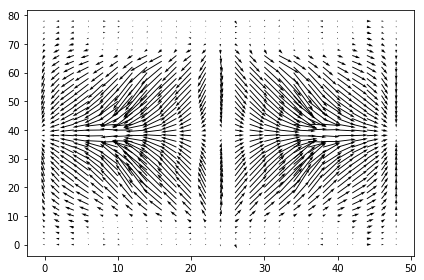

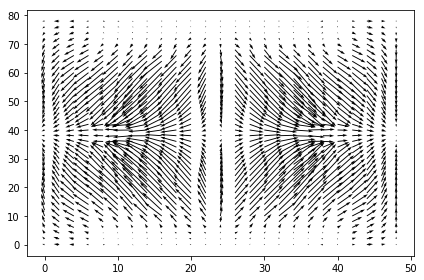

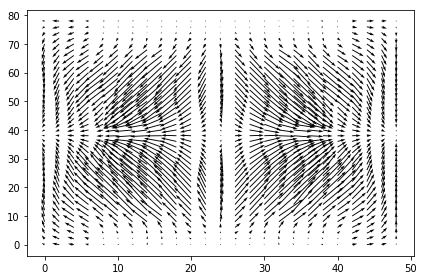

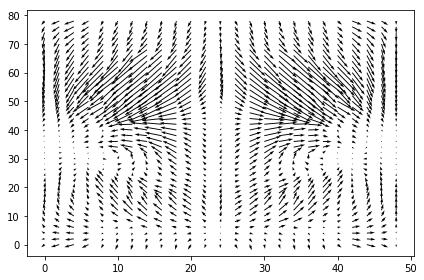

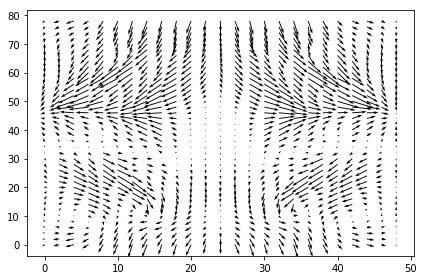

In [61]:
for i in range(8):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    spacing = 2
    time = im_shape[0]
    x_shape = im_shape[1]
    y_shape = im_shape[2]
    im_show = []
    (X, T, Y) = np.meshgrid(np.arange(0, x_shape), np.arange(0, time), np.arange(0, y_shape))
    Q = ax.quiver(X[0,::spacing,::spacing], Y[0,::spacing,::spacing], 
                       video_v_x[i,::spacing,::spacing], video_v_y[i,::spacing,::spacing], 
                        pivot='tail', color='k', units='xy', scale = .05)
    im_show.append(Q)
    plt.tight_layout()
    plt.savefig('figs/quiver_tianyi{}.png'.format(i),bbox_inches='tight')

## Estimating the velocity (translation and rotation) and depth of the stimulus 

Just from the optic flow information, the translation (only the direction, because the absolute translation and the depth are multiplied in equations for their estimation), the rotation and the depth (with some amount of error) can be obtained, using a linear subspace method as outlined by Heeger and Jepson (1992), and reviewed in Raudies and Neumann (2012).

### Estimating the direction of translation
The translation vector (henceforth a unit vector, $T$) can be recovered by calculating the estimated minimum of the residual function $E(T)$ calculated as follows. $v(x,y)$ represents the velocity (optic flow) at the point $(x,y)$ in the 2D optic plane, and $C(T)$ is a calculated matrix which does not need the optic flow information and hence can be precomputed in a parallel way beforehand from the image characteristics:

$$
\begin{equation}
v(x,y) = p(x,y)A(x,y)T + B(x,y)\Omega
\end{equation}\\
p(x,y) = \frac{1}{Z} \\
A(x,y) =
\begin{bmatrix}
-f & 0 & x \\
0 & -f & y \\
\end{bmatrix}\\
B(x,y) =
\begin{bmatrix}
(xy)/f & -(f + x^{2}/f) & y\\
f + y^{2}/f & -(xy)/f & -x\\
\end{bmatrix}\\
A(T) = 
\begin{bmatrix}
A(x_{1},y_{1})T & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & A(x_{N},y_{N})T\\
\end{bmatrix}\\
B = 
\begin{bmatrix}
B(x_{1},y_{1}) \\
\vdots \\
B(x_{N},y_{N})\\
\end{bmatrix}\\
C(T) = 
\begin{bmatrix}
\vdots & \vdots\\
A(T) & B\\
\vdots & \vdots\\
\end{bmatrix}\\
$$

Once we calculate $C(T)$, we calculate the residual function $E(T)$ as follows :

$$
E(T) = ||(I - \bar{C}\bar{C}^{t})v||^{2}\\
\implies E(T) = ||v^{t}C^{\bot}(T)||^{2}
$$
where the two expressions can be shown to be equivalent. $\bar{C}$ can be shown to be an orthogonal component which is obtained by QR decomposition of the matrix $C$. In the second expression, $C^{\bot}(T)$ is an orthogonal complement to $C(T)$. The minimum argument of $T$ which achieves this is taken to be the candidate translation direction. 

### Estimating the value of rotation, given the direction of translation




In [13]:
size = (im_shape[1],im_shape[2])
print(size)

(49, 79)


In [14]:
def calculate_CT(sample_points, T): #input the presampled points
    N = np.shape(sample_points)[0]; #justincase
    A_T = np.zeros([2*N,N]) #preallocate ndarrays for storing the matrices
    B = np.zeros([2*N,3])
    
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        xscaled = x - np.int(size[0]/2)
        yscaled = y - np.int(size[1]/2)
        
        #calculating A_T
        A = np.array([[-f,0,xscaled],[0,-f,yscaled]])
        AtimesT = np.dot(A,T)
        A_T[2*i,i], A_T[2*i+1,i] = AtimesT[0], AtimesT[1]
        
        #calculating B
        B[2*i] = np.array([(xscaled*yscaled)/f, -(f + (xscaled*xscaled)/f), yscaled])
        B[2*i+1] = np.array([f + (yscaled*yscaled)/f, -(xscaled*yscaled)/f, -xscaled])
    
    return np.concatenate((A_T,B),axis=1)

def calculate_projected_CT(sample_points,T):
    N = np.shape(sample_points)[0]; #justincase
    CT = calculate_CT(sample_points,T)
    CTbar, r = np.linalg.qr(CT)
    I = np.identity(2*N)
    cc = np.dot(CTbar,np.transpose(CTbar))
    return (I - cc)

def calculate_v(sample_points,time_id):
    sample_v_x, sample_v_y = video_v_x[time_id,sample_points[:,0],sample_points[:,1]], video_v_y[time_id,sample_points[:,0],sample_points[:,1]]
    v = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(2*N,1)
    return v

def calculate_CT_parallel_inner(params):
    idtheta, idphi,patch_id = params[0],params[1],params[2]
    theta,phi = idtheta/100,idphi/100
    x = np.cos(theta)*np.sin(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(phi)
    T = np.array([[x],[y],[z]])
    sample_points = im_patches[:,:,patch_id]
    projected_CT = calculate_projected_CT(sample_points,T) #the time consumer
    np.save('new_ct_estimate/new_ct_estimate_patchid{}_idtheta{}_idphi{}.npy'.format(patch_id,idtheta,idphi),projected_CT)

    
## if time permits, try double optimisations, but remember that daemonic processes cannnot have children
## that was called calculate_CT_parallel_outer, and hence the moniker inner above

def calculate_E(params): #tentative, check use of sample_points, T or using patch_no, phi, theta
    idtheta, idphi, patch_id, time_id = params[0],params[1],params[2],params[3]    
    sample_points = im_patches[:,:,patch_id]
    projected_CT = np.load('new_ct_estimate/new_ct_estimate_patchid{}_idtheta{}_idphi{}.npy'.format(patch_id,idtheta,idphi))
    v = calculate_v(sample_points,time_id)
    E_T = (np.linalg.norm(np.dot(projected_CT,v)))**2
    return (patch_id,idtheta,idphi,E_T)
    

In [15]:
x_lim = size[0]
y_lim = size[1]
N = 8 #number of random points in each patch
f = 15 #focal length
patch1d = 3
num_patches = 0

im_patches = np.transpose([[np.random.randint(0,10,size=N),np.random.randint(0,10,size=N)]])
for x_split in np.arange(0,patch1d*np.int(x_lim/patch1d),np.int(x_lim/patch1d)):
    for y_split in np.arange(0,patch1d*np.int(y_lim/patch1d),np.int(y_lim/patch1d)):
        sample_points = np.transpose([np.random.randint(x_split,x_split+np.int(x_lim/patch1d),size=N),np.random.randint(y_split,y_split+np.int(y_lim/patch1d),size=N)])
        im_patches = np.dstack((im_patches,sample_points))
        num_patches += 1
im_patches = im_patches[:,:,1:]

In [16]:
%%time
##this is to be ran only once at the beginning of the video
CPU_NUMBER = os.cpu_count()
if __name__ == '__main__':
    search_range = np.arange(0,np.int(100*np.pi),1)
    patch_id_range = range(num_patches)
    paramlist = list(itertools.product(search_range,search_range,patch_id_range))
    pool = Pool(CPU_NUMBER)
    pool.map(calculate_CT_parallel_inner,paramlist)

CPU times: user 1.14 s, sys: 276 ms, total: 1.41 s
Wall time: 8min


In [17]:
%%time

## this is to be run as the video runs - repeatedly
CPU_NUMBER = os.cpu_count()
if __name__=='__main__':
    for time_id in range(time):
        time_id_range = np.arange(time_id,time_id+1,1)
        search_range = np.arange(0,np.int(100*np.pi),1)
        patch_id_range = range(num_patches)
        paramlist = list(itertools.product(search_range,search_range,patch_id_range,time_id_range))
        pool = Pool()
        res = pool.map(calculate_E,paramlist)
        np.save('res/res_time{}.npy'.format(time_id),res)
        print('Calculated for time step {}'.format(time_id))

Calculated for time step 0
Calculated for time step 1
Calculated for time step 2
Calculated for time step 3
Calculated for time step 4
Calculated for time step 5
Calculated for time step 6
Calculated for time step 7
Calculated for time step 8
CPU times: user 38.4 s, sys: 23.7 s, total: 1min 2s
Wall time: 1h 4min 20s


In [51]:
%%time
for time_id in range(time):
    res = np.load('res/res_time{}.npy'.format(time_id))
    E = np.zeros((np.size(search_range),np.size(search_range)))
    for item in res:
        E[np.int(item[1]),np.int(item[2])]+=  item[3]
    idtheta, idphi = np.unravel_index(E.argmin(), E.shape)
    theta, phi = idtheta/100, idphi/100
    x_final = np.abs(np.cos(theta)*np.sin(phi))
    y_final = np.abs(np.sin(theta)*np.sin(phi))
    z_final = np.abs(np.cos(phi))
    T_final = np.array([[x_final],[y_final],[z_final]])
    
    #rotation also
    sum_left = np.zeros([3,3])
    sum_right = np.zeros([3,1])

    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        xscaled = x - (size[0]/2)
        yscaled = y - (size[1]/2)
        #calculating d
        A = np.array([[-f,0,xscaled],[0,-f,yscaled]])
        AtimesT = np.dot(A,T_final)
        d = np.array([[AtimesT[1,0]],[-AtimesT[0,0]]])
        di = d/linalg.norm(d)

        #calculating left term in omega estimate
        Bi = np.array([[(xscaled*yscaled)/f, -(f + (xscaled*xscaled)/f), yscaled],[f + (yscaled*yscaled)/f, -(xscaled*yscaled)/f, -xscaled]])
        sum_left += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),Bi)))
        
        #calculating right term in omega estimate
        sample_v_x,sample_v_y = video_v_x[time_id,x,y],video_v_y[time_id,x,y]
        vi = np.array([[sample_v_x],[sample_v_y]])
        sum_right += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),vi)))

    omega = np.dot(linalg.inv(sum_left),sum_right)
    np.save('res/tr_rot_time{}.npy'.format(time_id),(T_final,omega))
    print('Motion for time {} is : \n translation :\n{}\n rotation :\n{}\n'.format(time_id,T_final,omega))


Motion for time 0 is : 
 translation :
[[ 0.95823738]
 [ 0.12682994]
 [ 0.25631091]]
 rotation :
[[ 0.0017801 ]
 [ 0.00357504]
 [-0.00355426]]

Motion for time 1 is : 
 translation :
[[ 0.90826733]
 [ 0.41655049]
 [ 0.03919363]]
 rotation :
[[ 0.00252492]
 [ 0.00411589]
 [ 0.00477189]]

Motion for time 2 is : 
 translation :
[[ 0.90552277]
 [ 0.39356845]
 [ 0.158532  ]]
 rotation :
[[ 0.00060796]
 [-0.00028127]
 [ 0.00366064]]

Motion for time 3 is : 
 translation :
[[ 0.14868977]
 [ 0.37141209]
 [ 0.91648481]]
 rotation :
[[-0.02289194]
 [-0.03254914]
 [-0.01407975]]

Motion for time 4 is : 
 translation :
[[ 0.12695792]
 [ 0.36969257]
 [ 0.92043962]]
 rotation :
[[-0.03260208]
 [-0.04429046]
 [-0.02008879]]

Motion for time 5 is : 
 translation :
[[ 0.12325471]
 [ 0.37094364]
 [ 0.92043962]]
 rotation :
[[-0.032413  ]
 [-0.04367711]
 [-0.01992021]]

Motion for time 6 is : 
 translation :
[[ 0.73951723]
 [ 0.52794801]
 [ 0.4175945 ]]
 rotation :
[[-0.00179857]
 [-0.00031509]
 [ 0.0060

In [26]:
size[1]

79

### Estimating the value of the depth given the direction of translation and the rotation
From the equation $v(x,y) = p(x,y)A(x,y)T + B(x,y)\Omega$, we can substitute the values of $T$ and $\Omega$ to get the estimated depth at every point of the image

In [27]:
%matplotlib inline

#calculating depth
print (x_lim, y_lim)
for time_id in range(time):
    depth_mat0 = np.zeros([x_lim,y_lim])
    depth_mat1 = np.zeros([x_lim,y_lim])
    for x in np.arange(0,x_lim,1):
        for y in np.arange(0,y_lim,1):
            T, omega = np.load('res/tr_rot_time{}.npy'.format(time_id))
            xscaled = x - (size[0]/2)
            yscaled = y - (size[1]/2)
            A = np.array([[-f,0,xscaled],[0,-f,yscaled]])
            B = np.array([[(xscaled*yscaled)/f, -(f + (xscaled*xscaled)/f), yscaled],[f + (yscaled*yscaled)/f, -(xscaled*yscaled)/f, -xscaled]])
            v = np.array([[video_v_x[time_id,x,y]],[video_v_y[time_id,x,y]]])

            scaled_AT = v - np.dot(B,omega)
            act_AT = np.dot(A,T)
            depth0 = (act_AT/scaled_AT)
            depth_mat0[x,y] = depth0[0]
            depth_mat1[x,y] = depth0[1]
    np.save('res/dep_mat0_{}'.format(time_id),depth_mat0)
    np.save('res/dep_mat1_{}'.format(time_id),depth_mat1)


49 79


In [28]:
im_patches[:,:,1]

array([[ 6, 31],
       [13, 28],
       [ 5, 48],
       [ 2, 27],
       [11, 31],
       [ 9, 32],
       [ 4, 27],
       [ 8, 31]])

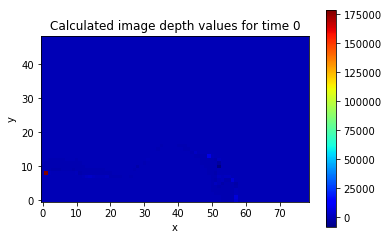

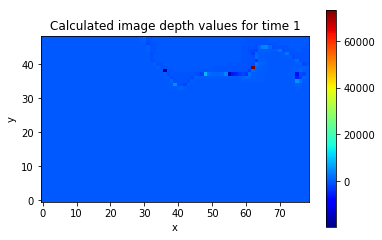

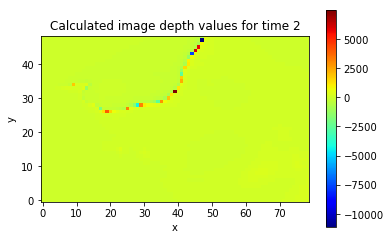

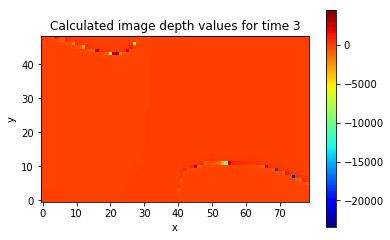

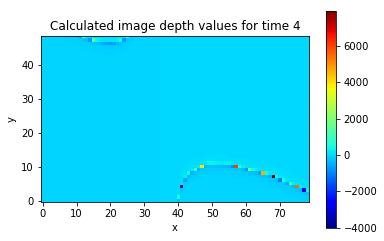

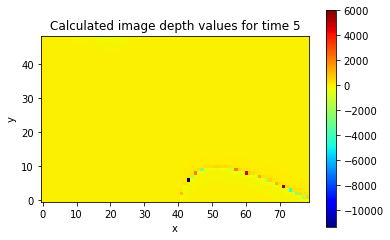

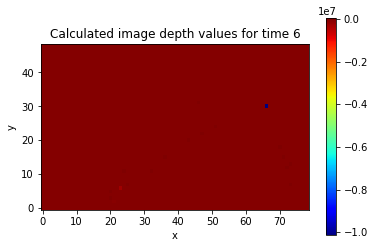

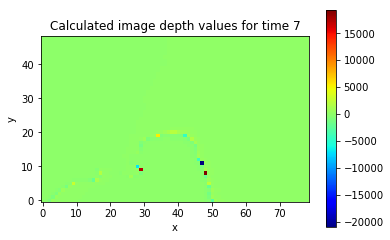

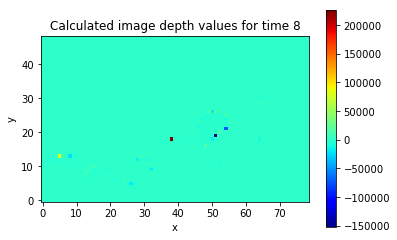

In [30]:
#plotting depth
%matplotlib inline
for time_id in range(time):
    depth_mat = np.load('res/dep_mat1_{}.npy'.format(time_id))
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    im = ax.imshow(depth_mat, cmap="jet",origin = "lower")
    fig.colorbar(im)
    ax.set_title('Calculated image depth values for time {}'.format(time_id))
    plt.savefig('figs/calculated_depth.png', bbox_inches='tight')